In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import nbimporter
import time
import pywt

from scipy.signal import butter, filtfilt, medfilt, savgol_filter as sg_builtin
from scipy.ndimage import gaussian_filter1d

from code_ import savgol_filter, read_csv_multi
from snr import compute_snr
from RMSE import compute_rmse


Filter Performance:
Savitzky–Golay  SNR= 34.72 dB   RMSE=2.0339
Moving Average  SNR= 20.29 dB   RMSE=10.3306
Gaussian        SNR= 24.32 dB   RMSE=6.5917
Butterworth     SNR= 29.38 dB   RMSE=3.7593
Median          SNR= 28.05 dB   RMSE=4.3457
Wavelet         SNR= 22.93 dB   RMSE=7.6454


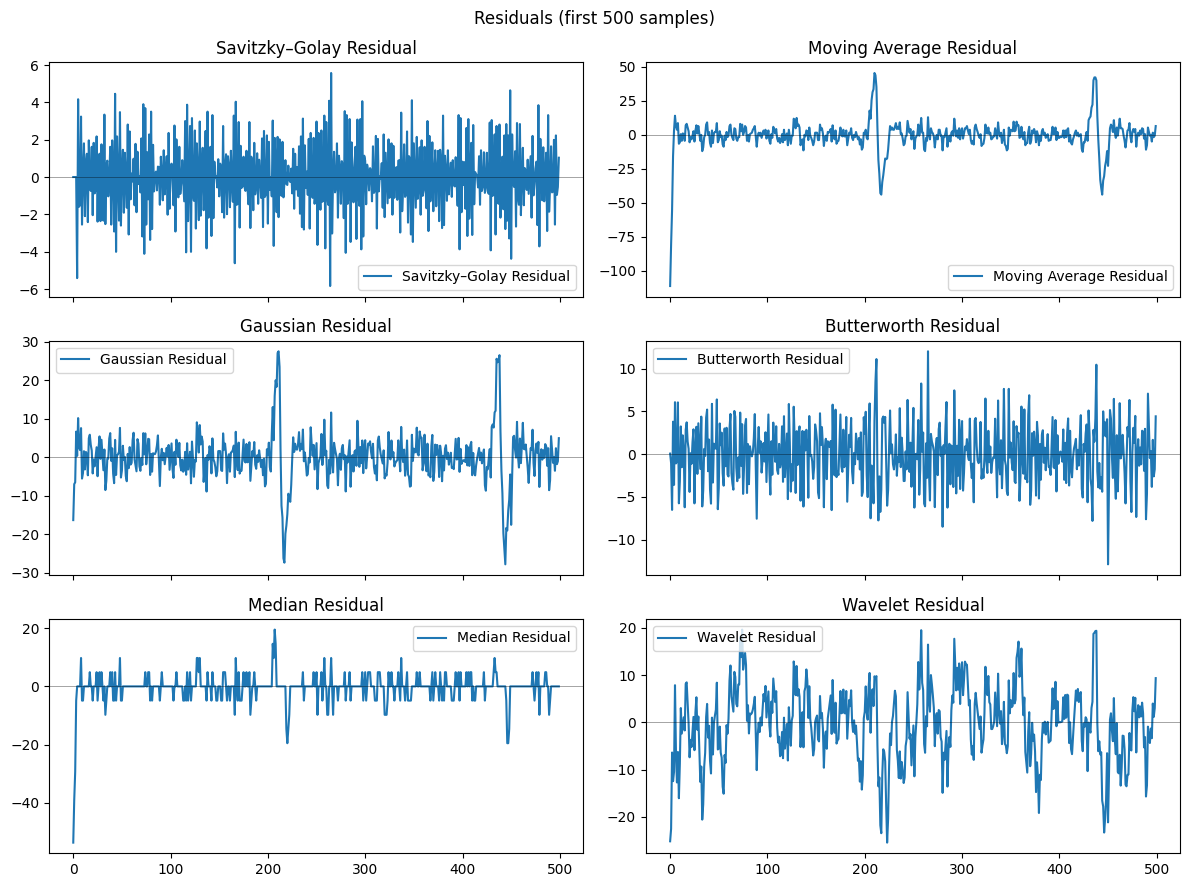

In [ ]:
def moving_average(sig, w=5):
    return np.convolve(sig, np.ones(w)/w, mode='same')

def gaussian_filter(sig, sigma=2):
    return gaussian_filter1d(sig, sigma)

def butterworth_filter(sig, cutoff=40, fs=360, order=4):
    nyq = 0.5*fs
    b, a = butter(order, cutoff/nyq, btype='low')
    return filtfilt(b, a, sig)

def median_filter(sig, w=5):
    return medfilt(sig, kernel_size=w)

def wavelet_denoise(sig, wavelet='db6', level=3):
    coeffs = pywt.wavedec(sig, wavelet, mode='per')
    sigma = np.median(np.abs(coeffs[-1]))/0.6745
    uth   = sigma*np.sqrt(2*np.log(len(sig)))
    coeffs[1:] = [pywt.threshold(c, value=uth, mode='soft') for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet, mode='per')

# ---------- main -------------
file = 'ECGData/MUSE_20180111_155115_19000.csv'
signal = np.array(read_csv_multi(file)[0])

window, poly = 9, 6
filtered = {
    'Savitzky–Golay': savgol_filter(signal, window, poly),
    'Moving Average' : moving_average(signal, window),
    'Gaussian'       : gaussian_filter(signal, sigma=2),
    'Butterworth'    : butterworth_filter(signal, cutoff=40, fs=360, order=4),
    'Median'         : median_filter(signal, window),
    'Wavelet'        : wavelet_denoise(signal)
}

print("\nFilter Performance:")
for name, sig_f in filtered.items():
    print(f"{name:<14}  SNR={compute_snr(signal, sig_f):6.2f} dB   RMSE={compute_rmse(signal, sig_f):.4f}")

# --- графік залишків ---
t   = np.arange(500)      # 0 … 499
seg = slice(0, 500)       # перші 500 семплів

n    = len(filtered)
rows = int(np.ceil(n / 2))
fig, axs = plt.subplots(rows, 2, figsize=(12, 3 * rows), sharex=True)
axs = axs.flatten()

for ax, (name, sig_f) in zip(axs, filtered.items()):
    res = signal[seg] - sig_f[seg]
    ax.plot(t, res, label=f'{name} Residual')
    ax.axhline(0, color='k', lw=0.5, alpha=0.5)
    ax.set_title(f'{name} Residual')
    ax.legend()

fig.suptitle('Residuals (first 500 samples)')
plt.tight_layout()
plt.show()


In [77]:
def compute_psnr(original, denoised):
    """
    Computes Peak Signal-to-Noise Ratio (PSNR) in decibels between original and denoised signals.
    """
    original = np.array(original)
    denoised = np.array(denoised)
    mse = np.mean((original - denoised) ** 2)
    if mse == 0:
        return np.inf
    peak = np.max(original) - np.min(original)
    return 10 * np.log10((peak ** 2) / mse)

# Load data
filename = 'ECGData/MUSE_20180111_155115_19000.csv'
channels = read_csv_multi(filename)
signal = np.array(channels[0])

filters = {
    'Savitzky–Golay': lambda sig: savgol_filter(sig, window_size=11, poly_order=8),
    'Moving Average': lambda sig: moving_average(sig, 11),
    'Gaussian': lambda sig: gaussian_filter(sig, sigma=2),
    'Butterworth': lambda sig: butterworth_filter(sig, cutoff=40, fs=360, order=4)
}
results = []
for name, func in filters.items():
    start = time.time()
    filtered = func(signal)
    elapsed_ms = (time.time() - start) * 1000
    snr = compute_snr(signal, filtered)
    rmse = compute_rmse(signal, filtered)
    psnr = compute_psnr(signal, filtered)
    results.append({
        'Method': name,
        'SNR (dB)': round(snr, 2),
        'RMSE': round(rmse, 4),
        'PSNR': round(psnr, 4),
        'Time (ms)': round(elapsed_ms, 2)
    })

df = pd.DataFrame(results)
print(df.to_string(index=False))

        Method  SNR (dB)    RMSE    PSNR  Time (ms)
Savitzky–Golay     35.59  1.8416 50.1916      12.90
Moving Average     17.64 13.8115 32.6908       0.23
      Gaussian     24.32  6.5917 39.1156       0.73
   Butterworth     29.38  3.7593 43.9934       1.96


In [ ]:

# 1. parameters
# --------------------------------------------------
ecg_dir      = "ECGData"
window_sizes = list(range(3, 31, 2))      # 3,5,7,…,29
poly_orders  = list(range(1, 10))         # 1…9
max_files    = 100                        # use only 100 files
max_samples  = 2000                       # cut each channel to 2k pts (optional)

# --------------------------------------------------
# 2. file subset
# --------------------------------------------------
all_files = sorted([os.path.join(ecg_dir, f)
                    for f in os.listdir(ecg_dir)
                    if f.endswith(".csv")])[:max_files]

print(f"Running grid search on {len(all_files)} ECG files "
      f"({len(window_sizes)}×{len(poly_orders)} combinations)…\n")

# --------------------------------------------------
# 3. main loop
# --------------------------------------------------
results = {}      # key = (w,p)  → mean SNR

for w, p in product(window_sizes, poly_orders):
    if p >= w:                      # skip over-fitting cases
        continue
    snr_per_file = []

    for path in all_files:
        try:
            chans = read_csv_multi(path)[:3]         # first 3 leads
            # truncate for speed
            chans = [ch[:max_samples] for ch in chans]

            snrs = []
            for ch in chans:
                filt = savgol_filter(ch, window_size=w, poly_order=p)
                snrs.append(compute_snr(ch, filt))
            snr_per_file.append(np.mean(snrs))

        except Exception as e:
            print(f"Skipped {os.path.basename(path)}: {e}")

    if snr_per_file:
        results[(w, p)] = np.mean(snr_per_file)
        print(f"w={w:2d}, p={p}  → mean SNR = {results[(w,p)]:.2f} dB")

# --------------------------------------------------
# 4. determine best combo
# --------------------------------------------------
best_combo, best_snr = max(results.items(), key=lambda kv: kv[1])
best_w, best_p = best_combo
print(f"\nBest overall: window={best_w}, poly_order={best_p}, "
      f"mean SNR={best_snr:.2f} dB")

# --------------------------------------------------
# 5. heat-map
# --------------------------------------------------
heat = np.full((len(poly_orders), len(window_sizes)), np.nan)
for i, p in enumerate(poly_orders):
    for j, w in enumerate(window_sizes):
        if (w, p) in results:
            heat[i, j] = results[(w, p)]

plt.figure(figsize=(12, 6))
sns.heatmap(heat, annot=True, fmt=".2f", cmap="viridis",
            xticklabels=window_sizes, yticklabels=poly_orders)
plt.title("Mean SNR across 100 ECG files (3 leads each)")
plt.xlabel("Window size (w)")
plt.ylabel("Polynomial order (p)")
plt.tight_layout()
plt.show()


Running grid search on 100 ECG files (14×9 combinations)…

w= 3, p=1  → mean SNR = 23.53 dB
w= 3, p=2  → mean SNR = 313.20 dB
w= 5, p=1  → mean SNR = 18.34 dB
w= 5, p=2  → mean SNR = 27.44 dB
w= 5, p=3  → mean SNR = 27.44 dB
w= 5, p=4  → mean SNR = 294.75 dB
w= 7, p=1  → mean SNR = 15.35 dB
w= 7, p=2  → mean SNR = 22.79 dB
w= 7, p=3  → mean SNR = 22.79 dB
w= 7, p=4  → mean SNR = 29.22 dB
w= 7, p=5  → mean SNR = 29.22 dB
w= 7, p=6  → mean SNR = 284.16 dB
w= 9, p=1  → mean SNR = 13.05 dB
w= 9, p=2  → mean SNR = 20.45 dB
w= 9, p=3  → mean SNR = 20.45 dB
w= 9, p=4  → mean SNR = 24.72 dB
w= 9, p=5  → mean SNR = 24.72 dB
w= 9, p=6  → mean SNR = 30.38 dB
w= 9, p=7  → mean SNR = 30.38 dB
w= 9, p=8  → mean SNR = 244.21 dB
w=11, p=1  → mean SNR = 11.14 dB
w=11, p=2  → mean SNR = 18.72 dB
w=11, p=3  → mean SNR = 18.72 dB
w=11, p=4  → mean SNR = 22.53 dB
w=11, p=5  → mean SNR = 22.53 dB
w=11, p=6  → mean SNR = 26.02 dB
w=11, p=7  → mean SNR = 26.02 dB
w=11, p=8  → mean SNR = 31.23 dB
w=11, p=9  → 

KeyboardInterrupt: 

Max |custom - built| = 6.241231e+00
RMS difference      = 1.263745e-01


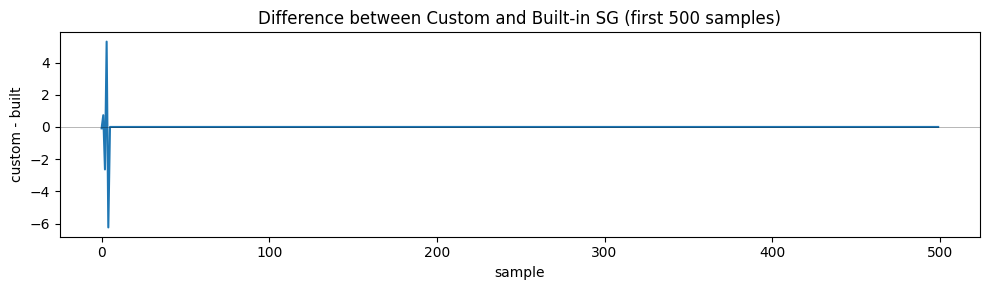

In [ ]:
# ---------- parameters ----------
w,p=11,8
cust=savgol_filter(signal,w,p)
built=sg_builtin(signal,window_length=w,polyorder=p,mode='interp')

# ---------- difference -------------
diff_signal = cust - built
max_abs=np.max(np.abs(diff_signal))
rms=np.sqrt(np.mean(diff_signal**2))

print(f"Max |custom - built| = {max_abs:.6e}")
print(f"RMS difference      = {rms:.6e}")

seg=slice(0,500)
plt.figure(figsize=(10,3))
plt.plot(np.arange(500), diff_signal[seg])
plt.axhline(0,color='k',lw=0.5,alpha=0.4)
plt.title('Difference between Custom and Built‑in SG (first 500 samples)')
plt.xlabel('sample')
plt.ylabel('custom - built')
plt.tight_layout()
plt.show()
